# Continous actions Actor Critic

Based on example avalaible [here](https://cs.stanford.edu/people/karpathy/convnetjs/demo/rldemo.html). Codes for original case are avalaible [here](https://github.com/karpathy/convnetjs/blob/4c3358a315b4d71f31a0d532eb5d1700e9e592ee/demo/js/rldemo.js).

Environment

In [1]:
using Random, LinearAlgebra, ReinforcementLearning, IntervalSets
using Flux
using Plots; gr()
import StatsBase.sample

Firstly, let us define objects existing in the environment:

In [2]:
struct Space{T}
    s::T
end

Random.rand(s::Space) = rand(Random.GLOBAL_RNG, s)

Random.rand(rng::AbstractRNG, s::Space) =
    map(s.s) do x
        rand(rng, x)
    end

function Base.in(X, S::Space)
    if length(X) == length(S.s)
        for (x, s) in zip(X, S.s)
            if x ∉ s
                return false
            end
        end
        return true
    else
        return false
    end
end

Base.size(s::Space) = size(s.s)
Base.length(s::Space) = length(s.s)

In [3]:
#Balls object - red ones (type "0") are poisonous and green ones (type "1") are edible 
mutable struct Ball{TI<:Integer, TF<:AbstractFloat}
    kind::TI #1 poison, 2 food
    loc::NamedTuple{(:x, :y), Tuple{TF, TF}}
    radius::Float64
    age::TI
end


#balls constructor
Ball(k) = k ∈ [1,2] ? Ball(k,(x =rand(), y = rand()),0.05, rand(1:100)) : @error "wrong type of object - it could be 1 or 2!"

Ball

And sensors that agent use to interact with the environment:

In [4]:
#definition of agent's eye:
mutable struct Eye{TI<:Integer, TF<:AbstractFloat}
    angle::TF
    max_range::TF
    sensed_proximity::TF
    sensed_type::TI #0 nothing; 1 poison, 2 food, 3 wall
end

Eye(a) = Eye(a, 0.2,0.2, 0)

Eye

Now, we could proceed with defining an environment:

In [5]:
mutable struct ContinuousLabirynthEnv <: AbstractEnv
    walls::Vector{Vector{NamedTuple{(:x, :y), Tuple{Float64, Float64}}}}
    nb::Int64
    balls::Vector{Ball{Int64, Float64}}
    observation_space::Space{Vector{ClosedInterval{Float64}}}
    action_space::Space{Vector{ClosedInterval{Float64}}}
    velocity::Vector{Float64}
    old_position::NamedTuple{(:x, :y), Tuple{Float64, Float64}}
    position::NamedTuple{(:x, :y), Tuple{Float64, Float64}}
    radius::Float64
    angle::Float64
    eyes::Vector{Eye{Int64, Float64}}
    digestion_signal::Float64
end
Main.ContinuousLabirynthEnv

ContinuousLabirynthEnv

In [6]:
function ContinuousLabirynthEnv(nb; radius = 0.05)
    walls = [#bounds of the map:
        [(x = 0.0, y = 0.0),(x = 0.0, y = 1.0)],
        [(x = 0.0, y = 0.0),(x = 1.0, y = 0.0)],
        [(x = 1.0, y = 0.0),(x = 1.0, y = 1.0)],
        [(x = 0.0, y = 1.0),(x = 1.0, y = 1.0)],
        #walls inside the map:
        [(x = 0.1, y = 0.1),(x = 0.3, y = 0.1)],
        [(x = 0.1, y = 0.9),(x = 0.3, y = 0.9)],
        [(x = 0.3, y = 0.1),(x = 0.3, y = 0.9)],
        
        [(x = 0.7, y = 0.1),(x = 0.9, y = 0.1)],
        [(x = 0.7, y = 0.9),(x = 0.9, y = 0.9)],
        #[(x = 0.9, y = 0.1),(x = 0.9, y = 0.9)], #can be use instead of the latter one:
        [(x = 0.7, y = 0.1),(x = 0.7, y = 0.9)]
        ]
    balls = [Ball(rand([1,2])) for i = 1:nb]
    position = (x = rand(), y = rand());
    eyes = [Eye((k - 4)*0.25) for k = 1:9];
    observation_space = Space([0.0..1.0 for i = 1:(3 * length(eyes))])
    action_space = Space([0.0..1.0, 0.0..1.0])
    return ContinuousLabirynthEnv(walls, nb, balls, observation_space, action_space, [0.0, 0.0],
            position, position, radius, 0.0, eyes, 0.0)
end

ContinuousLabirynthEnv

Auxilliary functions - physics of the environment:

In [7]:
#rotate a vector clockwise https://en.wikipedia.org/wiki/Rotation_matrix

rot(vec, angle) = [cos(angle) sin(angle); -sin(angle) cos(angle)] * vec

rot (generic function with 1 method)

In [8]:
#line circle intersect: 
#https://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
function intersect(vec,centre,radius)
    v = values(vec[2]) .- values(vec[1])
    a = sum(v.*v)
    b = 2* sum(v .* (values(vec[1]) .- values(centre)))
    c =  sum(values(vec[1]) .* values(vec[1])) + sum(values(centre) 
        .* values(centre)) - 2 * sum(values(vec[1]) .* values(centre)) - radius ^2
    Δ = b^2 - 4*a*c
    if Δ < 0
        return false
    else
        t₁ = (-b + √Δ)/(2*a)
        t₂ = (-b - √Δ)/(2*a)
        if 0.0 ≤ t₁ ≤ 1 || 0.0 ≤ t₂ ≤ 1
            p₁= values(vec[1]) .+ t₁ .* v
            p₂ = values(vec[1]) .+ t₂ .* v
            norm(p₁ .- values(vec[1])) < norm(p₂ .- values(vec[1])) ? (return p₁) : (return p₂)
        else
            return false
        end 
    end
end

intersect (generic function with 1 method)

In [9]:
#interscetion of two lines:
#http://www-cs.ccny.cuny.edu/~wolberg/capstone/intersection/Intersection%20point%20of%20two%20lines.html
function intersect(vec1,vec2)
    denominator = (vec2[2].y - vec2[1].y)*(vec1[2].x - vec1[1].x) - (vec2[2].x - vec2[1].x)*(vec1[2].y - vec1[1].y)
    denominator == 0.0 && (return false)
    u₁ = ((vec2[2].x - vec2[1].x)*(vec1[1].y - vec2[1].y) - (vec2[2].y - vec2[1].y)*(vec1[1].x - vec2[1].x)) / denominator
    u₂ = ((vec1[2].x - vec1[1].x)*(vec1[1].y - vec2[1].y) - (vec1[2].y - vec1[1].y)*(vec1[1].x - vec2[1].x)) / denominator
    (0.0 ≤ u₁ ≤ 1.0 &&  0.0 ≤ u₂ ≤ 1.0) ? (return (vec1[1].x + u₁ * (vec1[2].x - vec1[1].x),
                                                    vec1[1].y + u₁ * (vec1[2].y - vec1[1].y))) : (return false) 
end




intersect (generic function with 2 methods)

Other auxilliary functions:

In [10]:
#vector of agent's eyesight:
eyesight(env, eye) = [env.position, (x = env.position.x + sin(env.angle + eye.angle)*eye.sensed_proximity, 
                            y = env.position.y + cos(env.angle + eye.angle)*eye.sensed_proximity)]

eyesight(env) = [eyesight(env,eye) for eye in env.eyes]

eyesight (generic function with 2 methods)

In [11]:
#plotting 
function Plots.plot(env::ContinuousLabirynthEnv)
    p = Plots.plot(framestyle = :none, legend=:none)
    
    for wall in env.walls
        plot!([w.x for w in wall],[w.y for w in wall], linewidth=2, c = :blue)
    end
    
    scatter!([ball.loc.x for ball in env.balls if ball.kind == 1], 
            [ball.loc.y for ball in env.balls if ball.kind == 1], 
            color=:red, m = :circle, markersize=16, alpha=0.6)

    scatter!([ball.loc.x for ball in env.balls if ball.kind == 2], 
            [ball.loc.y for ball in env.balls if ball.kind == 2], 
            color=:green, m = :circle, markersize=16, alpha=0.6)
    
    scatter!([env.position.x,], [env.position.y,], color=:orange, markersize=20, alpha=0.8)

    for eye in eyesight(env) 
        plot!([e.x for e in eye],[e.y for e in eye], linewidth=0.5, c = :black,alpha=0.6)
    end
    display(p) 
end

Finally, the most important functions:

In [12]:
#functions:
RLBase.action_space(env::ContinuousLabirynthEnv) = env.action_space

"""
    state_space(env::ContinuousLabirynthEnv)

State is represented as  vector three times number of eyes and is coded as follows:
-every three neighboring values are representing a signal visible by one eye, e.g. 
 [1.0, 1.0, 0.14] means that agent do not see any edible balls (first value of vector)
nor poisons (second value of vector), but see the wall in the proximity of 0.14
"""
RLBase.state_space(env::ContinuousLabirynthEnv) = env.observation_space

function RLBase.state(env::ContinuousLabirynthEnv, ::Observation, ::DefaultPlayer) 
    state = ones(Float64, length(env.observation_space))
    for (i, eye) in enumerate(env.eyes)
        eye.sensed_type == 0 && continue 
        state[(i-1)*3 + eye.sensed_type] = eye.sensed_proximity/eye.max_range
    end
    return state
end

function RLBase.reward(env::ContinuousLabirynthEnv)
    #agent do not like to see walls, especially up close:
    proximity_reward = 0.0
    for eye in env.eyes
        if eye.sensed_type == 3
            proximity_reward -= 1 - eye.sensed_proximity/eye.max_range
        elseif eye.sensed_type != 0
            proximity_reward += 1 - eye.sensed_proximity/eye.max_range
        end
    end
    #agent like to go forward:
    forward_reward = 0.0
    if env.old_position == env.position 
        forward_reward += -1.0
    else
        forward_reward += 1.0
    end
    ##agent also like to eat good things:
    return env.digestion_signal + proximity_reward + forward_reward
end

RLBase.is_terminated(env::ContinuousLabirynthEnv) = false
function RLBase.reset!(env::ContinuousLabirynthEnv) 
    env.position = (x = rand(), y = rand());
    env.angle = 0.0
    env.digestion_signal = 0.0
end

In [13]:
#check if agent do not fall from the map:
on_boundary(vec) = any(vec .≤ 0.0) || any(vec .≥ 1.0)

#check if agent do not collide with a wall:
function collide(env, vec)
    for wall in env.walls
        if intersect(wall,vec,env.radius) != false 
            env.angle  += π/2 #we turn agent 180° to avoid him stucking in the wall 
            return true 
        end
    end
    return false
end

collide (generic function with 1 method)

In [14]:
#movement function of agent
function turnaround_and_move!(env, action)
    #agent's movement is caused by the two  wheels rotating with different velocities and directions (action) 
    #wheels are perpendicular to the direction agent is facing at the moment
    
    #firstly we must find the positions of the wheels
    #we will rotate agent's radius by 90°:
    vec = rot([0.0, env.radius],env.angle + π/2)
    #now, we could find the positions of both wheels:
    wheel_1 = [env.position.x + vec[1], env.position.y + vec[2]] 
    wheel_2 = [env.position.x - vec[1], env.position.y - vec[2]] 
    #rotate first wheel, clockwise:
    vel_clockwise = rot(-1 .* vec, action.v1)
    #rotate second wheel, counterclockwise:
    vel_counterclockwise = rot(vec, -action.v2)
    #new position of first wheel:
    wheel_1 = [wheel_1[1] + vel_clockwise[1], wheel_1[2] + vel_clockwise[2]]
    #new position of second wheel:
    wheel_2 = [wheel_2[1] + vel_counterclockwise[1], wheel_2[2] + vel_counterclockwise[2]]
    #new position of agent is just an average of the positions of both wheels:
    new_position = [wheel_1[1] + wheel_2[1], wheel_1[2] + wheel_2[2]] ./ 2
    
    #now we must adjust the angle that agent is facing:
    env.angle += action.v1
    env.angle > 2*π && (env.angle -= 2 * π)
    env.angle -= action.v2
    env.angle < 0 && (env.angle += 2 * π)
    
    #and check if new position is feasible:
    if !(collide(env, new_position) || on_boundary(new_position))
        env.old_position = deepcopy(env.position)
        env.position  = (x = new_position[1], y = new_position[2])
   end 
end

turnaround_and_move! (generic function with 1 method)

In [15]:
#uaktualniamy obiekty, ktore widzi agent:
#dla kazdego oka sprawdzamy czy widzi jakis objekt lub sciane, jezeli tak to w jakiej odleglosci
#dodatkowo patrzymy czy agent nic nie zjadl - nie przecial sie z kulka oznaczajaca jedzenie
function look_at_things_and_eat!(env)
    for eye in env.eyes
        eye.sensed_proximity = eye.max_range
        eye.sensed_type = 0
        eye_sight = eyesight(env,eye)
        for wall in env.walls
            intersect_point = intersect(eye_sight,wall)
            intersect_point == false && continue 
            proximity = norm(values(env.position) .- intersect_point)
            if proximity < eye.sensed_proximity
                eye.sensed_proximity = proximity
                eye.sensed_type = 3
            end
        end
        for ball in env.balls
            intersect_point = intersect(eye_sight,ball.loc, ball.radius)
            intersect_point == false && continue 
            proximity = norm(values(env.position) .- intersect_point)
            if proximity < eye.sensed_proximity
                if proximity < (env.radius + ball.radius)
                    ball.kind == 2 ? (env.digestion_signal = 20.0) : (env.digestion_signal = -30.0)
                    ball.age = 9999999999999 
                else
                    eye.sensed_proximity = proximity
                    eye.sensed_type = ball.kind
                end
            end 
        end
    end
end


look_at_things_and_eat! (generic function with 1 method)

In [16]:
function update_balls!(env)
    for ball in env.balls
        ball.age += 1
    end
    env.balls = filter(ball -> ball.age < 500, env.balls)
    for new_ball in 1:(env.nb - length(env.balls))
        push!(env.balls, Ball(rand([1,2])))
    end    
end

update_balls! (generic function with 1 method)

In [17]:
function RLBase.act!(x::ContinuousLabirynthEnv, action)
    @assert action in action_space(x)
    x.velocity = [action.v1, action.v2]
    x.digestion_signal = 0.0
    turnaround_and_move!(x, action)
    look_at_things_and_eat!(x)
    update_balls!(x)
end

Now, time for brain:

In [18]:
struct PolicyNet
    common::Flux.Chain
    μ::Dense
    logσ::Dense
end

Flux.@layer PolicyNet

function (policy_net::PolicyNet)(state)
    Z = policy_net.common(state)
    mu = policy_net.μ(Z)
    logsigma = policy_net.logσ(Z)
    return mu, logsigma
end

In [19]:
mutable struct Brain
    experience_size::Int64
    experience::Array
    min_experience_size::Int64
    policy_net::PolicyNet
    value_net::Flux.Chain
    ηₚ::Float64
    ηᵥ::Float64
    opt_state_p::NamedTuple
    opt_state_v::NamedTuple
    β::Float64
    batch_size::Int64
end

In [20]:
function Brain(input_size; experience_size = 3000, min_memory_size = 1000, ηₚ = .01, ηᵥ = 0.001, β = 0.95, batch_size = 64)
    policy_net = PolicyNet(Chain(Dense(input_size,128,relu),Dense(128, 64,relu), Dense(64, 32, identity)), 
                            Dense(32, 2, sigmoid),
                            Dense(32, 2, sigmoid))
    opt_state_p = Flux.setup(Adam(ηₚ), policy_net) 
    value_net = Chain(Dense(input_size,128,identity),
        Dense(128, 64,relu),Dense(64, 32,relu),Dense(32, 1,identity));
    opt_state_v = Flux.setup(Adam(ηᵥ), value_net)
    return Brain(experience_size, [], min_memory_size, policy_net, value_net, 
                ηₚ, ηᵥ, opt_state_p, opt_state_v, β, batch_size)
end

Brain

and Agent:

In [21]:
mutable struct ContinuousAgent
    env::ContinuousLabirynthEnv 
    brain::Brain
end

In [22]:
function ContinuousAgent(nb)
    env = ContinuousLabirynthEnv(nb)
    brain = Brain(length(state_space(env)))
    return ContinuousAgent(env,brain)
end

ContinuousAgent

In [23]:
function forward(brain, state)
    v = brain.value_net(state)
    mu, logsigma = brain.policy_net(state)
    return v[1], mu, logsigma
end

forward (generic function with 1 method)

In [24]:
function remember!(brain::Brain, step::Tuple)
    length(brain.experience) == brain.experience_size && deleteat!(brain.experience,1)
    push!(brain.experience, step)
end

remember! (generic function with 1 method)

In [25]:
critic_loss(m, x, y, ξ = 0.5) = ξ*Flux.mse(m(x), y)


critic_loss (generic function with 2 methods)

In [26]:
function gaussian_loss(m, s, a, v, γ = 0.001)
    mu, logsigma = m(s)
    sigma = exp.(logsigma)
    pdf_val = 1 ./ (sigma .* sqrt(2*π)) .* exp.(-0.5 .* ((a .- mu) ./ sigma).^2)
    log_prob = log.(pdf_val .+ 1e-7)
    entropy = sum(-log.(pdf_val .+ 1e-7) .* pdf_val) / length(log_prob)
    return sum(-log_prob .* v) / length(log_prob) - γ * entropy
end

gaussian_loss (generic function with 2 methods)

In [27]:
function replay!(agent::ContinuousAgent)
    S = zeros(Float32,length(state(agent.env)), agent.brain.batch_size)
    A = zeros(Float32,length(action_space(agent.env)), agent.brain.batch_size)
    Adv = zeros(Float32, 1, agent.brain.batch_size)
    V = zeros(Float32,1, agent.brain.batch_size)
    for (i,step)  in enumerate(sample(agent.brain.experience, agent.brain.batch_size, replace = false))
        s,a,r,s′,v,v′ = step
        R = r + agent.brain.β * v′
        adv = R - v
        S[:, i] .= s
        A[:, i] .= a
        Adv[:, i] .= adv
        V[:, i] .= R
    end
    
    Flux.train!(gaussian_loss, agent.brain.policy_net, [(S,A,Adv)], agent.brain.opt_state_p)
    Flux.train!(critic_loss, agent.brain.value_net, [(S, V)], agent.brain.opt_state_v)
    #push!(agent.losses, gaussian_loss(S,A,R))
end

replay! (generic function with 1 method)

In [28]:
function step!(agent::ContinuousAgent,  training::Bool)
    s = deepcopy(state(agent.env))
    v, μ,logσ = forward(agent.brain, s)
    a = μ + exp.(logσ) .* randn(length(logσ))
    a = (Flux.tanh.(a) .+1 ) ./ 2
    act!(agent.env, (v1 = a[1], v2 = a[2]))
    r = deepcopy(reward(agent.env))
    s′ = deepcopy(state(agent.env))
    v′,_ ,_ = forward(agent.brain, s′)
    remember!(agent.brain, (s,a,r,s′,v,v′))
    (training && length(agent.brain.experience) > agent.brain.min_experience_size) && replay!(agent)
end

step! (generic function with 1 method)

In [34]:
function run!(agent::ContinuousAgent, steps::Int; training::Bool = true,
            plotting::Bool = true, summary::Bool = true)
    step = 1.0
    while step ≤ steps
        if plotting 
            IJulia.clear_output(true)
            plot(agent.env) |> IJulia.display
            sleep(0.01)
        end
        (training && mod(step, 2_500) == 0) && reset!(agent.env)
        step!(agent, training)
        if summary && mod(step,10_000) == 0
            @info "step $(Int(step))"
            @info "Reward: $(reward(agent.env))"
            s,a,r,s′,v,v′ = agent.brain.experience[end]
            @info "actor loss: $(gaussian_loss(agent.brain.policy_net, s,a, (r + agent.brain.β *  v′) - v))"
            @info "critc loss: $(critic_loss(agent.brain.value_net, s,r + agent.brain.β *  v′))"
        end
        step += 1.0
    end
end


run! (generic function with 1 method)

In [35]:
agent = ContinuousAgent(50);

In [36]:
run!(agent,1_000_000, plotting = false, summary = true)

[ Info: step 10000
[ Info: Reward: -27.84136371583365
[ Info: actor loss: -5.936638951403023
[ Info: critc loss: 22.060907699397088
[ Info: step 20000
[ Info: Reward: 1.118011428905517
[ Info: actor loss: 3.586752654922079
[ Info: critc loss: 5.045336161622939
[ Info: step 30000
[ Info: Reward: 21.46069643357807
[ Info: actor loss: 32.62036702705267
[ Info: critc loss: 634.4045193565838
[ Info: step 40000
[ Info: Reward: -26.709083148610773
[ Info: actor loss: 3.4306693703238347
[ Info: critc loss: 7.699289187322508
[ Info: step 50000
[ Info: Reward: -28.429147921023226
[ Info: actor loss: -0.8889529844134464
[ Info: critc loss: 0.5965716460878899
[ Info: step 60000
[ Info: Reward: -30.403533590240794
[ Info: actor loss: -44.481385513036436
[ Info: critc loss: 827.8531063308359
[ Info: step 70000
[ Info: Reward: -26.840197541983557
[ Info: actor loss: -44.12670674644181
[ Info: critc loss: 1070.5129352284791
[ Info: step 80000
[ Info: Reward: -28.541578056284063
[ Info: actor loss: -18

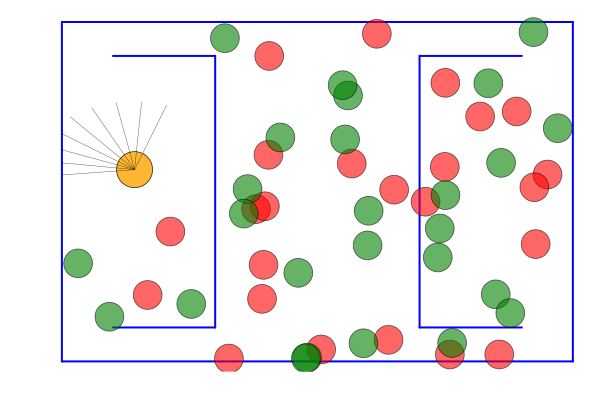

nothing

In [38]:
run!(agent,1000, plotting = true,training = false, summary = true)